###requirements

In [ ]:
#!pip install opencv-python

In [ ]:
#!pip install mediapipe opencv-python pandas scikit-learn

In [ ]:
#!pip install mediapipe

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt
import time
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

####Mediapipe Initialization

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

#MediaPipe Functions

In [3]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    # Draw landmarks
    draw_styled_landmarks(image, results)
    return image, results

In [ ]:
# Function to calculate the maximum distance between any node and the hips center
# def calculate_max_distance(pose_landmarks, hip_center):
#     max_distance = 0
#     for landmark in pose_landmarks:
#         distance = np.sqrt((landmark[0] - hip_center[0]) ** 2 + (landmark[1] - hip_center[1]) ** 2)
#         if distance > max_distance:
#             max_distance = distance
#     return max_distance
# # Function to transform landmarks relative to hip center point and normalize based on maximum distance
# def transform_landmarks(results):
#     transformed_face_landmarks = []
#     transformed_left_hand_landmarks = []
#     transformed_right_hand_landmarks = []
#     transformed_pose_landmarks = []

#     face_landmarks = results.face_landmarks
#     left_hand_landmarks = results.left_hand_landmarks
#     right_hand_landmarks = results.right_hand_landmarks
#     pose_landmarks = results.pose_landmarks

#     # Calculate the center point of the hips
#     left_hip_x = pose_landmarks.landmark[mp.solutions.holistic.PoseLandmark.LEFT_HIP].x
#     left_hip_y = pose_landmarks.landmark[mp.solutions.holistic.PoseLandmark.LEFT_HIP].y
#     right_hip_x = pose_landmarks.landmark[mp.solutions.holistic.PoseLandmark.RIGHT_HIP].x
#     right_hip_y = pose_landmarks.landmark[mp.solutions.holistic.PoseLandmark.RIGHT_HIP].y
#     hip_center = ((left_hip_x + right_hip_x)/2, (left_hip_y + right_hip_y)/2)

#     # Transform face landmarks
#     if face_landmarks is not None:
#         for landmark in face_landmarks.landmark:
#             transformed_x = landmark.x - hip_center[0]
#             transformed_y = landmark.y - hip_center[1]
#             transformed_z = landmark.z
#             transformed_face_landmarks.append((transformed_x, transformed_y, transformed_z))

#     # Transform left hand landmarks
#     if left_hand_landmarks is not None:
#         for landmark in left_hand_landmarks.landmark:
#             transformed_x = landmark.x - hip_center[0]
#             transformed_y = landmark.y - hip_center[1]
#             transformed_z = landmark.z
#             transformed_left_hand_landmarks.append((transformed_x, transformed_y, transformed_z))

#     # Transform right hand landmarks
#     if right_hand_landmarks is not None:
#         for landmark in right_hand_landmarks.landmark:
#             transformed_x = landmark.x - hip_center[0]
#             transformed_y = landmark.y - hip_center[1]
#             transformed_z = landmark.z
#             transformed_right_hand_landmarks.append((transformed_x, transformed_y, transformed_z))

#     # Transform pose landmarks
#     if pose_landmarks is not None:
#         for landmark in pose_landmarks.landmark:
#             transformed_x = landmark.x - hip_center[0]
#             transformed_y = landmark.y - hip_center[1]
#             transformed_z = landmark.z
#             transformed_pose_landmarks.append((transformed_x, transformed_y, transformed_z))

#     # Calculate maximum distance
#     max_distance = max(calculate_max_distance(transformed_face_landmarks, (0, 0)),
#                        calculate_max_distance(transformed_left_hand_landmarks, (0, 0)),
#                        calculate_max_distance(transformed_right_hand_landmarks, (0, 0)),
#                        calculate_max_distance(transformed_pose_landmarks, (0, 0)))

#     # Normalize all landmarks
#     normalized_face_landmarks = [(x / max_distance, y / max_distance, z) for x, y, z in transformed_face_landmarks]
#     normalized_left_hand_landmarks = [(x / max_distance, y / max_distance, z) for x, y, z in transformed_left_hand_landmarks]
#     normalized_right_hand_landmarks = [(x / max_distance, y / max_distance, z) for x, y, z in transformed_right_hand_landmarks]
#     normalized_pose_landmarks = [(x / max_distance, y / max_distance, z) for x, y, z in transformed_pose_landmarks]

#     return normalized_pose_landmarks,normalized_face_landmarks, normalized_left_hand_landmarks, normalized_right_hand_landmarks,


In [5]:
# Function to calculate the maximum distance between any node and the hips center
def calculate_max_distance(pose_landmarks, hip_center):
    max_distance = 0
    for landmark in pose_landmarks:
        distance = np.sqrt((landmark[0] - hip_center[0]) ** 2 + (landmark[1] - hip_center[1]) ** 2)
        if distance > max_distance:
            max_distance = distance
    return max_distance

def transform_landmarks(results):
    transformed_face_landmarks = []
    transformed_left_hand_landmarks = []
    transformed_right_hand_landmarks = []
    transformed_pose_landmarks = []

    face_landmarks = results.face_landmarks
    left_hand_landmarks = results.left_hand_landmarks
    right_hand_landmarks = results.right_hand_landmarks
    pose_landmarks = results.pose_landmarks

    # Calculate the center point of the hips
    if pose_landmarks is not None:
        left_hip_x = pose_landmarks.landmark[mp.solutions.holistic.PoseLandmark.LEFT_HIP].x
        left_hip_y = pose_landmarks.landmark[mp.solutions.holistic.PoseLandmark.LEFT_HIP].y
        right_hip_x = pose_landmarks.landmark[mp.solutions.holistic.PoseLandmark.RIGHT_HIP].x
        right_hip_y = pose_landmarks.landmark[mp.solutions.holistic.PoseLandmark.RIGHT_HIP].y
        hip_center = ((left_hip_x + right_hip_x) / 2, (left_hip_y + right_hip_y) / 2)
    else:
        hip_center = (0, 0)

    # Transform face landmarks
    if face_landmarks is not None:
        for landmark in face_landmarks.landmark:
            transformed_x = landmark.x - hip_center[0]
            transformed_y = landmark.y - hip_center[1]
            transformed_z = landmark.z
            transformed_face_landmarks.append((transformed_x, transformed_y, transformed_z))
    else:
        transformed_face_landmarks = [(0, 0, 0)] * 468

    # Transform left hand landmarks
    if left_hand_landmarks is not None:
        for landmark in left_hand_landmarks.landmark:
            transformed_x = landmark.x - hip_center[0]
            transformed_y = landmark.y - hip_center[1]
            transformed_z = landmark.z
            transformed_left_hand_landmarks.append((transformed_x, transformed_y, transformed_z))
    else:
        transformed_left_hand_landmarks = [(0, 0, 0)] * 21

    # Transform right hand landmarks
    if right_hand_landmarks is not None:
        for landmark in right_hand_landmarks.landmark:
            transformed_x = landmark.x - hip_center[0]
            transformed_y = landmark.y - hip_center[1]
            transformed_z = landmark.z
            transformed_right_hand_landmarks.append((transformed_x, transformed_y, transformed_z))
    else:
        transformed_right_hand_landmarks = [(0, 0, 0)] * 21

    # Transform pose landmarks
    if pose_landmarks is not None:
        for landmark in pose_landmarks.landmark:
            transformed_x = landmark.x - hip_center[0]
            transformed_y = landmark.y - hip_center[1]
            transformed_z = landmark.z
            transformed_pose_landmarks.append((transformed_x, transformed_y, transformed_z))
    else:
        transformed_pose_landmarks = [(0, 0, 0)] * 33

    # Calculate maximum distance
    max_distance = max(calculate_max_distance(transformed_face_landmarks, (0, 0)),
                       calculate_max_distance(transformed_left_hand_landmarks, (0, 0)),
                       calculate_max_distance(transformed_right_hand_landmarks, (0, 0)),
                       calculate_max_distance(transformed_pose_landmarks, (0, 0)))

    # Normalize all landmarks
    normalized_face_landmarks = [(x / max_distance, y / max_distance, z) for x, y, z in transformed_face_landmarks]
    normalized_left_hand_landmarks = [(x / max_distance, y / max_distance, z) for x, y, z in transformed_left_hand_landmarks]
    normalized_right_hand_landmarks = [(x / max_distance, y / max_distance, z) for x, y, z in transformed_right_hand_landmarks]
    normalized_pose_landmarks = [(x / max_distance, y / max_distance, z) for x, y, z in transformed_pose_landmarks]

    return normalized_pose_landmarks, normalized_face_landmarks, normalized_left_hand_landmarks, normalized_right_hand_landmarks

In [6]:
def extract_landmarks(frames):
    # Initialize MediaPipe Holistic model
    mp_holistic = mp.solutions.holistic.Holistic(static_image_mode=False)

    # Open webcam
    cap = cv2.VideoCapture(0)  # 0 indicates the default webcam

    landmark_data = []
    frame_count = 0

    while frame_count < frames:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        
        image, results = mediapipe_detection(frame, mp_holistic)
        
        
        transformed_results = transform_landmarks(results)
        
        


        # Extract pose landmarks
        if transformed_results[0]:
            for idx, landmark in enumerate(transformed_results[0]):
                landmark_data.append({
                    'frame': frame_count,
                    'row_id': f"{frame_count}-pose-{idx}",
                    'type': 'pose',
                    'landmark_index': idx,
                    'x': landmark[0],
                    'y': landmark[1],
                    'z': landmark[2]  # Optional, depending on your needs
                })

        # Extract face landmarks
        if transformed_results[1]:
            for idx, landmark in enumerate(transformed_results[1]):
                landmark_data.append({
                    'frame': frame_count,
                    'row_id': f"{frame_count}-face-{idx}",
                    'type': 'face',
                    'landmark_index': idx,
                    'x': landmark[0],
                    'y': landmark[1],
                    'z': landmark[2]  # Optional, depending on your needs
                })

        # Extract left hand landmarks
        if transformed_results[2]:
            for idx, landmark in enumerate(transformed_results[2]):
                landmark_data.append({
                    'frame': frame_count,
                    'row_id': f"{frame_count}-left_hand-{idx}",
                    'type': 'left_hand',
                    'landmark_index': idx,
                    'x': landmark[0],
                    'y': landmark[1],
                    'z': landmark[2]  # Optional, depending on your needs
                })

        # Extract right hand landmarks
        if transformed_results[3]:
            for idx, landmark in enumerate(transformed_results[3]):
                landmark_data.append({
                    'frame': frame_count,
                    'row_id': f"{frame_count}-right_hand-{idx}",
                    'type': 'right_hand',
                    'landmark_index': idx,
                    'x': landmark[0],
                    'y': landmark[1],
                    'z': landmark[2]  # Optional, depending on your needs
                })

        # Display the frame
        cv2.imshow('Live Feed', frame)

        # Check for 'q' key press to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release resources
    cap.release()
    mp_holistic.close()
    cv2.destroyAllWindows()

    return pd.DataFrame(landmark_data)

In [ ]:
# def extract_landmarks(frames):
#     # Initialize MediaPipe Holistic model
#     mp_holistic = mp.solutions.holistic.Holistic(static_image_mode=False)

#     # Open webcam
#     cap = cv2.VideoCapture(0)  # 0 indicates the default webcam

#     landmark_data = []
#     frame_count = 0

#     while frame_count < frames:
#         ret, frame = cap.read()
#         if not ret:
#             break

#         frame_count += 1

#         image, results = mediapipe_detection(frame,mp_holistic)


#         # Draw landmarks
#         draw_styled_landmarks(image, results)

#         # Extract pose landmarks
#         if results.pose_landmarks:
#             for idx, landmark in enumerate(results.pose_landmarks.landmark):
#                 landmark_data.append({
#                     'frame': frame_count,
#                     'row_id': f"{frame_count}-pose-{idx}",
#                     'type': 'pose',
#                     'landmark_index': idx,
#                     'x': landmark.x,
#                     'y': landmark.y,
#                     'z': landmark.z  # Optional, depending on your needs
#                 })


#         # Extract face landmarks
#         if results.face_landmarks:
#             for idx, landmark in enumerate(results.face_landmarks.landmark):
#                 landmark_data.append({
#                     'frame': frame_count,
#                     'row_id': f"{frame_count}-face-{idx}",
#                     'type': 'face',
#                     'landmark_index': idx,
#                     'x': landmark.x,
#                     'y': landmark.y,
#                     'z': landmark.z  # Optional, depending on your needs
#                 })

#         # Extract left hand landmarks
#         if results.left_hand_landmarks:
#             for idx, landmark in enumerate(results.left_hand_landmarks.landmark):
#                 landmark_data.append({
#                     'frame': frame_count,
#                     'row_id': f"{frame_count}-left_hand-{idx}",
#                     'type': 'left_hand',
#                     'landmark_index': idx,
#                     'x': landmark.x,
#                     'y': landmark.y,
#                     'z': landmark.z  # Optional, depending on your needs
#                 })

#         # Extract right hand landmarks
#         if results.right_hand_landmarks:
#             for idx, landmark in enumerate(results.right_hand_landmarks.landmark):
#                 landmark_data.append({
#                     'frame': frame_count,
#                     'row_id': f"{frame_count}-right_hand-{idx}",
#                     'type': 'right_hand',
#                     'landmark_index': idx,
#                     'x': landmark.x,
#                     'y': landmark.y,
#                     'z': landmark.z  # Optional, depending on your needs
#                 })

#         # Display the frame
#         cv2.imshow('Live Feed', frame)

#         # Check for 'q' key press to exit
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

#     # Release resources
#     cap.release()
#     mp_holistic.close()
#     cv2.destroyAllWindows()

#     return pd.DataFrame(landmark_data)

In [7]:
def count_files_in_folder(folder_path):
    # List all files and directories in the specified folder
    items = os.listdir(folder_path)
    
    # Count the number of files (excluding directories) in the folder
    file_count = sum(1 for item in items if os.path.isfile(os.path.join(folder_path, item)))
    
    return file_count

#CAM code

In [8]:
folder_path = "E:\Engineering\HACKATHON\GIT\SignsData"

In [9]:
sign = input("Enter Sign : ").lower()
if not os.path.exists(os.path.join(folder_path, sign )):
        os.makedirs(os.path.join(folder_path, sign))
number_of_files = count_files_in_folder(os.path.join(folder_path, sign))
number_of_files

Enter Sign :  yes


0

In [10]:
num_frames = 20  # Change this to the desired number of frames
landmark_df = extract_landmarks(num_frames)

In [11]:
landmark_df['y']=landmark_df['y']*-1

In [12]:
landmark_df.to_csv(os.path.join(folder_path, sign, f'{sign}{number_of_files+1}.csv'), index=False)

In [13]:
def get_hand_points(hand):
    x = [[hand.iloc[0].x, hand.iloc[1].x, hand.iloc[2].x, hand.iloc[3].x, hand.iloc[4].x], # Thumb
         [hand.iloc[5].x, hand.iloc[6].x, hand.iloc[7].x, hand.iloc[8].x], # Index
         [hand.iloc[9].x, hand.iloc[10].x, hand.iloc[11].x, hand.iloc[12].x],
         [hand.iloc[13].x, hand.iloc[14].x, hand.iloc[15].x, hand.iloc[16].x],
         [hand.iloc[17].x, hand.iloc[18].x, hand.iloc[19].x, hand.iloc[20].x],
         [hand.iloc[0].x, hand.iloc[5].x, hand.iloc[9].x, hand.iloc[13].x, hand.iloc[17].x, hand.iloc[0].x]]

    y = [[hand.iloc[0].y, hand.iloc[1].y, hand.iloc[2].y, hand.iloc[3].y, hand.iloc[4].y],  #Thumb
         [hand.iloc[5].y, hand.iloc[6].y, hand.iloc[7].y, hand.iloc[8].y], # Index
         [hand.iloc[9].y, hand.iloc[10].y, hand.iloc[11].y, hand.iloc[12].y],
         [hand.iloc[13].y, hand.iloc[14].y, hand.iloc[15].y, hand.iloc[16].y],
         [hand.iloc[17].y, hand.iloc[18].y, hand.iloc[19].y, hand.iloc[20].y],
         [hand.iloc[0].y, hand.iloc[5].y, hand.iloc[9].y, hand.iloc[13].y, hand.iloc[17].y, hand.iloc[0].y]]
    return x, y

def get_pose_points(pose):
    x = [[pose.iloc[8].x, pose.iloc[6].x, pose.iloc[5].x, pose.iloc[4].x, pose.iloc[0].x, pose.iloc[1].x, pose.iloc[2].x, pose.iloc[3].x, pose.iloc[7].x],
         [pose.iloc[10].x, pose.iloc[9].x],
         [pose.iloc[22].x, pose.iloc[16].x, pose.iloc[20].x, pose.iloc[18].x, pose.iloc[16].x, pose.iloc[14].x, pose.iloc[12].x,
          pose.iloc[11].x, pose.iloc[13].x, pose.iloc[15].x, pose.iloc[17].x, pose.iloc[19].x, pose.iloc[15].x, pose.iloc[21].x],
         [pose.iloc[12].x, pose.iloc[24].x, pose.iloc[26].x, pose.iloc[28].x, pose.iloc[30].x, pose.iloc[32].x, pose.iloc[28].x],
         [pose.iloc[11].x, pose.iloc[23].x, pose.iloc[25].x, pose.iloc[27].x, pose.iloc[29].x, pose.iloc[31].x, pose.iloc[27].x],
         [pose.iloc[24].x, pose.iloc[23].x]
        ]

    y = [[pose.iloc[8].y, pose.iloc[6].y, pose.iloc[5].y, pose.iloc[4].y, pose.iloc[0].y, pose.iloc[1].y, pose.iloc[2].y, pose.iloc[3].y, pose.iloc[7].y],
         [pose.iloc[10].y, pose.iloc[9].y],
         [pose.iloc[22].y, pose.iloc[16].y, pose.iloc[20].y, pose.iloc[18].y, pose.iloc[16].y, pose.iloc[14].y, pose.iloc[12].y,
          pose.iloc[11].y, pose.iloc[13].y, pose.iloc[15].y, pose.iloc[17].y, pose.iloc[19].y, pose.iloc[15].y, pose.iloc[21].y],
         [pose.iloc[12].y, pose.iloc[24].y, pose.iloc[26].y, pose.iloc[28].y, pose.iloc[30].y, pose.iloc[32].y, pose.iloc[28].y],
         [pose.iloc[11].y, pose.iloc[23].y, pose.iloc[25].y, pose.iloc[27].y, pose.iloc[29].y, pose.iloc[31].y, pose.iloc[27].y],
         [pose.iloc[24].y, pose.iloc[23].y]
        ]
    return x, y

def animation_frame(f):
    plt.rcParams['animation.ffmpeg_path'] = "D:\Om\Python Projects\Testing MediaPipe\ffmpeg-master-latest-win64-gpl\bin\ffmpeg.exe"
    frame = df[df.frame==f]
    left = frame[frame.type=='left_hand']
    right = frame[frame.type=='right_hand']
    pose = frame[frame.type=='pose']
    face = frame[frame.type=='face'][['x', 'y']].values
    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)
    ## These values set the limits on the graph to stabilize the video
    xmin = df.x.min() - 0.2
    xmax = df.x.max() + 0.2
    ymin = df.y.min() - 0.2
    ymax = df.y.max() + 0.2
    
    ax.clear()
    ax.plot(face[:,0], face[:,1], '.')
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i])
    for i in range(len(px)):
        ax.plot(px[i], py[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

In [ ]:
#!pip install ffmpeg

The phrase being shown here is: yes


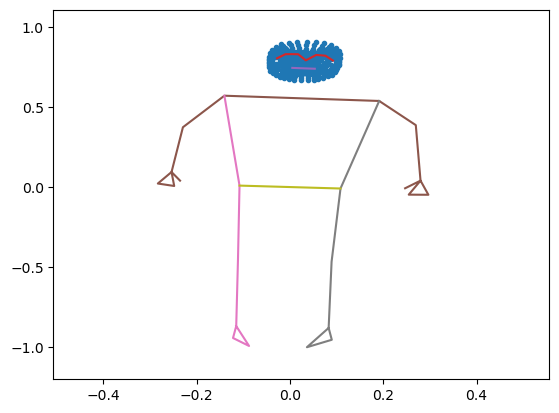

In [14]:
df = landmark_df
fig, ax = plt.subplots()
l, = ax.plot([], [])
animation = FuncAnimation(fig, func=animation_frame, frames=df.frame.unique())

print(f"The phrase being shown here is: {sign}")
HTML(animation.to_html5_video())
